<a href="https://colab.research.google.com/github/krumeto/COMS4995-s20/blob/master/Notes_on_aml_06_linear_models_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. Remember loss functions
- Same as linear regression, but results pushed to probabilities. > 0.5 Prova -> class 1
$log(p(y=1|x)/p(y=0|x)) = w^T*x + b$
- You minimize the negative probability over the samples
2. C is inverse of alpha (or alpha/n_samples)
3. On SVMs - remember, small C is less regularization, large C is more regularization.
4. If you need proba estimates - LogReg. If not - try either. 
Difference between logReg and SVMs - log loss vs hinge loss.
5. Multiclass classification:
- One vs Rest - n_classes classifiers, trained on imbalanced datasets of original size. Retains some uncertainty
- One vs One - n_classes* (n_classes - 1)/2 classifiers, trained on balanced subsets. No uncertainty propagated.
6. Implementation in Scikit-learn 
- OvO - only in SVC
- OvR - default for all linear models
- LogReg(multinomial=True)
LogisticRegression(multi_class="multinomial", solver="lbfgs")
- clf.decision_function = W^T*X + b
- logreg.predict_proba
7. Solver choices
- Don't ever use SVC(kernel='linear'), use LinearSVC
- For n_features >> n_samples: Lars (LassoLars) instead of Lasso
- For small n_samples (<10K) - reason
- LinearSVC, LogReg: dual=False if n_samples >> n_features
- LogReg(solver='sag') for n_samples large - important to scale the data (StandardScaler)
- Stochastic GD for n_samples really large - SGDClassifier/SGDRegressor
8. Kernel SVMs
- Idea - hope to get more powerful nonlinear one. Keep convexity. Generalize the concept of feature engineering.
- 
- Slow for large datasets
- RBF could learn (aka overfit) anything
- Important to scale - StandardScaler
- For RBF gamma - 1/n_features
- smaller gamma + smaller C - less complex models

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

cancer = load_breast_cancer()
X, y = scale(cancer.data), cancer.target
X.shape

(569, 30)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

logreg = LogisticRegression()
logreg.fit(X_train[:, :2], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

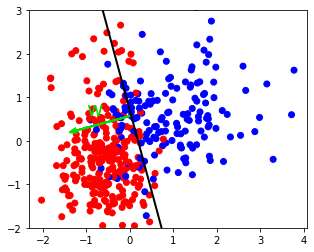

In [0]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="bwr")
coef = logreg.coef_.ravel()
line = np.linspace(X_train[:, 1].min(), X_train[:, 1].max())
line2 = - (line * coef[1]  + logreg.intercept_) / coef[0]
plt.plot(line2, line, c='k', linewidth=2)
plt.arrow(line2[20], line[20], .4 * coef[0], .4 * coef[1], color='#00dd00', linewidth=2, head_width=.1)
plt.text(-1, .6, "w", color='#00dd00', fontsize=20)
plt.ylim(-2, 3)
plt.gca().set_aspect("equal")
#plt.savefig("images/linear_boundary_vector.png")

Text(0, 0.5, '$L(y=1, w^Tx + b) $')

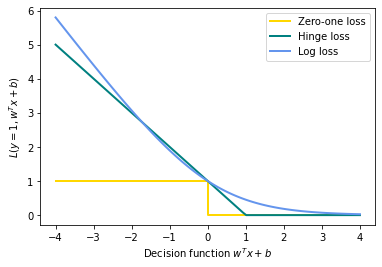

In [0]:
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], color='gold', lw=lw,
         label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), color='teal', lw=lw,
         label="Hinge loss")

plt.plot(xx, np.log2(1 + np.exp(-xx)), color='cornflowerblue', lw=lw,
         label="Log loss")
#plt.plot(xx, np.where(xx < 1, 1 - xx, 0) ** 2, color='orange', lw=lw,
#         label="Squared hinge loss")

#plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $w^Tx + b$")
plt.ylabel("$L(y=1, w^Tx + b) $")
#plt.savefig("images/binary_loss.png")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


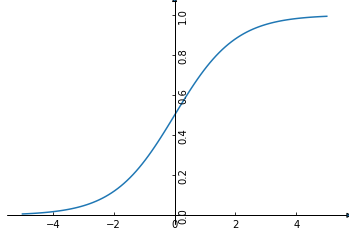

In [0]:
from mpl_toolkits.axes_grid.axislines import SubplotZero
fig = plt.figure()
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)

for direction in ["xzero", "yzero"]:
    ax.axis[direction].set_axisline_style("-|>")
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    ax.axis[direction].set_visible(False)

line =  np.linspace(-5, 5, 100)   
ax.plot(line, 1. / (1 + np.exp(-line)))

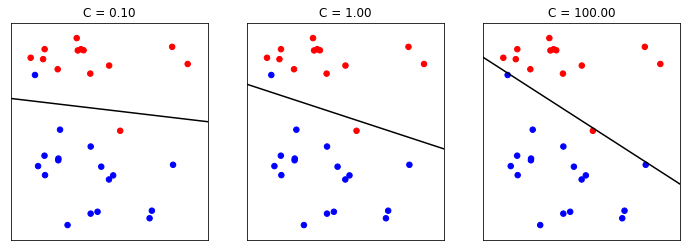

In [0]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(centers=2, random_state=4, n_samples=30)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# a carefully hand-designed dataset lol
y[7] = 0
y[27] = 0
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

for ax, C in zip(axes, [1e-1, 1, 1e2]):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, s=30)

    svm = LogisticRegression(solver='lbfgs', C=C, tol=0.00001).fit(X, y)
    # using SVC instead of LinearSVC so we can get support vectors more easily
    w = svm.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(6, 13)
    yy = a * xx - (svm.intercept_[0]) / w[1]
    ax.plot(xx, yy, c='k')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("C = %.2f" % C)
#plt.savefig("images/logreg_regularization.png")

# Multiclass

In [0]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)
print(np.bincount(y))

(150, 4)
[50 50 50]


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(X, y)
linearsvm = LinearSVC().fit(X, y)
print(logreg.coef_.shape)
print(linearsvm.coef_.shape)

(3, 4)
(3, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
logreg.coef_

array([[-0.41878528,  0.96703041, -2.5209973 , -1.08417682],
       [ 0.53124457, -0.31475282, -0.20008433, -0.94861142],
       [-0.1124593 , -0.65227759,  2.72108162,  2.03278825]])

In [0]:
logreg.intercept_

array([  9.84037025,   2.21700109, -12.05737134])

In [0]:
from sklearn.preprocessing import scale
logreg = LogisticRegression(fit_intercept=False, multi_class="multinomial", solver="lbfgs").fit(scale(X), y)

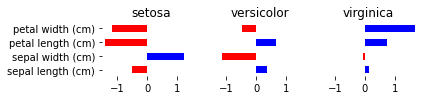

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(6, 1.5))
for ax, coef, classname in zip(axes, logreg.coef_, iris.target_names):
    ax.barh(range(4), coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    ax.set_xlim(logreg.coef_.min() - .1, logreg.coef_.max() + .1)

    ax.set_title(classname)
    ax.set_frame_on(False)
    ax.set_yticks(())
    
axes[0].set_yticks(range(4))
axes[0].set_yticklabels(iris.feature_names)
plt.tight_layout()


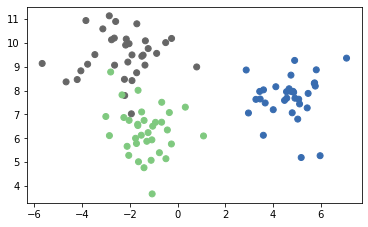

In [0]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=27)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
ax = plt.gca()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# OVR

In [0]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(C=100).fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(3.296917305477605, 11.504390064947742)

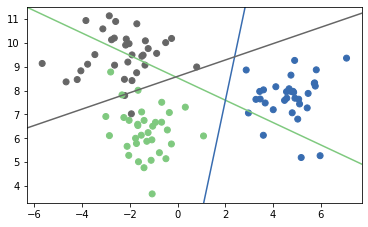

In [0]:
points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
colors = [plt.cm.Accent(i) for i in [0, 4, 7]]
line = np.linspace(X[:, 1].min() - 5, X[:, 1].max() + 5)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, colors):
    plt.plot(-(line * coef[1] + intercept) / coef[0], line, c=color)
plt.gca().set_aspect("equal")
plt.xlim(xlim)
plt.ylim(ylim)
#plt.savefig("images/ovr_lines.png")

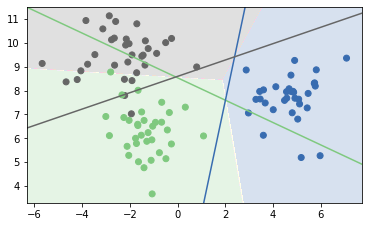

In [0]:
import matplotlib as mpl

xs = np.linspace(xlim[0], xlim[1], 1000)
ys = np.linspace(ylim[0], ylim[1], 1000)
xx, yy = np.meshgrid(xs, ys)
pred = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
plt.imshow(pred.reshape(xx.shape), cmap="Accent", alpha=.2, extent=(xlim[0], xlim[1], ylim[1], ylim[0]))
points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")

for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, colors):
    plt.plot(-(line * coef[1] + intercept) / coef[0], line, c=color)
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect("equal")
#plt.savefig("images/ovr_boundaries.png")

# OVO

In [0]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=100).fit(X, y)
points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
line = np.linspace(X[:, 1].min() - 5, X[:, 1].max() + 5)
classes = [(0, 1), (0, 2), (1, 2)]
for coef, intercept, col in zip(svm.coef_, svm.intercept_, classes):
    line2 = -(line * coef[1] + intercept) / coef[0]
    plt.plot(line2, line, "-", c=colors[col[0]])
    plt.plot(line2, line, "--", c=colors[col[1]])

plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect("equal")
#plt.savefig("images/ovo_lines.png")

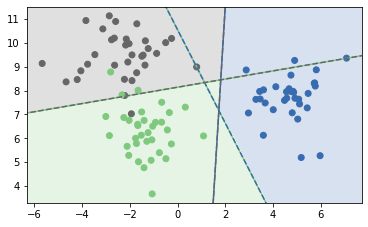

In [0]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=27)

svm = SVC(kernel="linear", C=100).fit(X, y)

points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
pred = svm.predict(np.c_[xx.ravel(), yy.ravel()])
plt.imshow(pred.reshape(xx.shape), cmap="Accent", alpha=.2, extent=(xlim[0], xlim[1], ylim[1], ylim[0]))
for coef, intercept, col in zip(svm.coef_, svm.intercept_, classes):
    line2 = -(line * coef[1] + intercept) / coef[0]
    plt.plot(line2, line, "-", c=colors[col[0]])
    plt.plot(line2, line, "--", c=colors[col[1]])
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect("equal")
#plt.savefig("images/ovo_boundaries.png")

# kernel SVMS

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


(-1.0, 3.5)

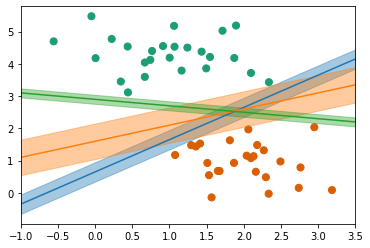

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.Dark2(y), s=50);
plt.xlim(-.6, 3.5)

xfit = np.linspace(-1, 3.5)

for m, b, d in [(1, 0.65, 0.3), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.14)]:
    yfit = m * xfit + b
    line, = plt.plot(xfit, yfit)
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     alpha=0.4, color=line.get_color())

plt.xlim(-1, 3.5)
#plt.savefig("images/max_margin.png")

Text(0.5, 1.0, 'C=1')

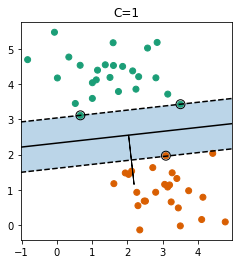

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
X[:, 0] *= 1.5
# fit the model
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(X[:, 0].min() - .2, X[:, 0].max() + .2)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin


# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.fill_between(xx, yy_down, yy_up, alpha=.3)
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.Dark2(y))
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=80, facecolors='none', edgecolor='k')
plt.arrow(xx[25], yy[25], w[0], w[1])
plt.gca().set_aspect("equal")
plt.xlim(xx[0], xx[-1])
plt.title("C=1")
#plt.savefig("images/max_margin_C_1.png")

Text(0.5, 1.0, 'C=0.1')

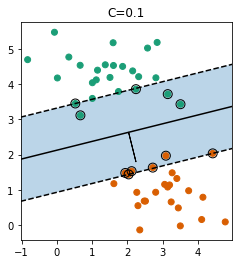

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# fit the model
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(X, y)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(X[:, 0].min() - .2, X[:, 0].max() + .2)

yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.fill_between(xx, yy_down, yy_up, alpha=.3)
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.Dark2(y))
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=80, facecolors='none', edgecolor='k')
plt.gca().set_aspect("equal")
plt.arrow(xx[25], yy[25], w[0], w[1])
plt.gca().set_aspect("equal")

plt.xlim(xx[0], xx[-1])
plt.title("C=0.1")
#plt.savefig("images/max_margin_C_0.1.png")

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_blobs

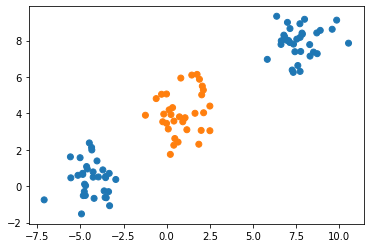

In [0]:
X, y = make_blobs(random_state=3)
y = (y == 0).astype(np.int)
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y))

In [0]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

In [0]:
X.shape, X_poly.shape

((100, 2), (100, 5))

In [0]:
poly.get_feature_names()

['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [0]:
linear_svm = SVC(kernel="linear").fit(X_poly, y)
poly_svm = SVC(kernel="poly", degree=2, coef0=1).fit(X, y)

In [0]:
linear_svm.coef_

array([[ 0.13850605,  0.05989699, -0.20119627,  0.0484241 ,  0.01907115]])

In [0]:
linear_svm.dual_coef_

array([[-0.02957404, -0.00341814,  0.00254448,  0.03044769]])

In [0]:
linear_svm.support_

array([ 1, 26, 42, 62], dtype=int32)

In [0]:
poly_svm.dual_coef_

array([[-1.        , -0.3044725 , -1.        , -0.30748025, -1.        ,
        -1.        ,  0.61195275,  1.        ,  1.        ,  1.        ,
         1.        ]])

In [0]:
poly_svm.support_

array([ 1, 22, 41, 45, 61, 79,  9, 21, 23, 38, 42], dtype=int32)

In [0]:
# create a grid for plotting decision functions...
x_lin = np.linspace(X[:, 0].min() - .5, X[:, 0].max() + .5, 1000)
y_lin = np.linspace(X[:, 1].min() - .5, X[:, 1].max() + .5, 1000)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

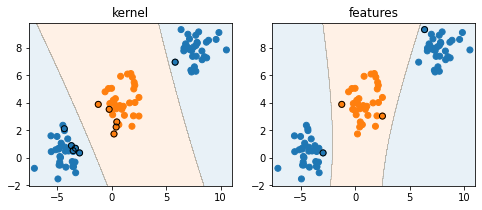

In [0]:
from sklearn.pipeline import make_pipeline
colors = [plt.cm.tab10(0), plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(1)]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for ax, model, name in zip(axes, [poly_svm, make_pipeline(poly, linear_svm)], ["kernel", "features"]):
    ax.set_title(name)
    support_vectors = getattr(model, "support_", None)
    if support_vectors is None:
        support_vectors = model.steps[1][1].support_
    predictions = model.predict(X_grid)
    ax.contourf(x_grid, y_grid, predictions.reshape(x_grid.shape), alpha=.1, colors=colors)
    ax.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y))
    ax.scatter(X[support_vectors, 0], X[support_vectors, 1], facecolor='none', edgecolor='k', linewidths=1)
    ax.set_xlim(x_lin[0], x_lin[-1])
    ax.set_ylim(y_lin[0], y_lin[-1])
#plt.savefig("images/poly_kernel_features.png")

# Scaling with number of samples

In [0]:
from time import time
from sklearn.svm import LinearSVC

linear, kernel = [], []
samples = [100, 1000, 10000, 100000] #, 1e6, 1e7]
for n_samples in samples:
    X, y = make_blobs(n_samples=int(n_samples), random_state=0)
    y = (y == 0).astype(np.int)
    X_poly = PolynomialFeatures(include_bias=False).fit_transform(X)

    tick = time()
    LinearSVC(dual=False).fit(X_poly, y)
    linear.append(time() - tick)
    tick = time()
    SVC(kernel="poly", degree=2, coef0=1).fit(X, y)
    kernel.append(time() - tick)

In [0]:
kernel

[0.000537872314453125,
 0.005238533020019531,
 0.49434590339660645,
 39.06058979034424]

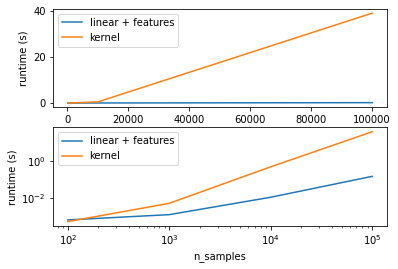

In [0]:
fig, axes = plt.subplots(2, 1)
for ax in axes:
    ax.plot(samples, linear, label="linear + features")
    ax.plot(samples, kernel, label="kernel")
    ax.set_ylabel("runtime (s)")
    ax.set_xlabel("n_samples")
    ax.legend()
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Scaling with n_features # FIXME NOT VERY GOOD

In [0]:
from sklearn.datasets import make_classification
linear, kernel = [], []
features = []
for n_features in features:
    X, y = make_classification(n_samples=10000, random_state=0, n_features=int(n_features))
    y = (y == 0).astype(np.int)
    X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)

    tick = time()
    LinearSVC(loss="hinge").fit(X_poly, y)
    linear.append(time() - tick)
    tick = time()
    SVC(kernel="poly", degree=2, coef0=1).fit(X, y)
    kernel.append(time() - tick)

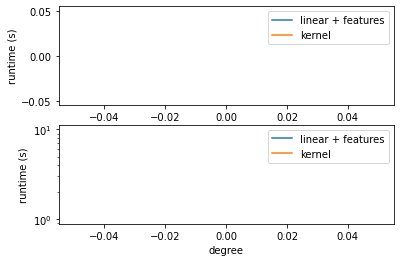

In [0]:
fig, axes = plt.subplots(2, 1)
for ax in axes:
    ax.plot(features, linear, label="linear + features")
    ax.plot(features, kernel, label="kernel")
    ax.set_ylabel("runtime (s)")
    ax.set_xlabel("degree")
    ax.legend()
axes[1].set_yscale("log")

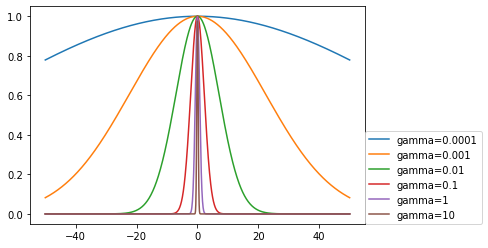

In [0]:
line = np.linspace(-50, 50, 1000)
def rbf(gamma):
    return np.exp(-gamma * line**2)

for gamma in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    plt.plot(line, rbf(gamma), label="gamma={}".format(gamma))
plt.legend(loc=(1, 0))

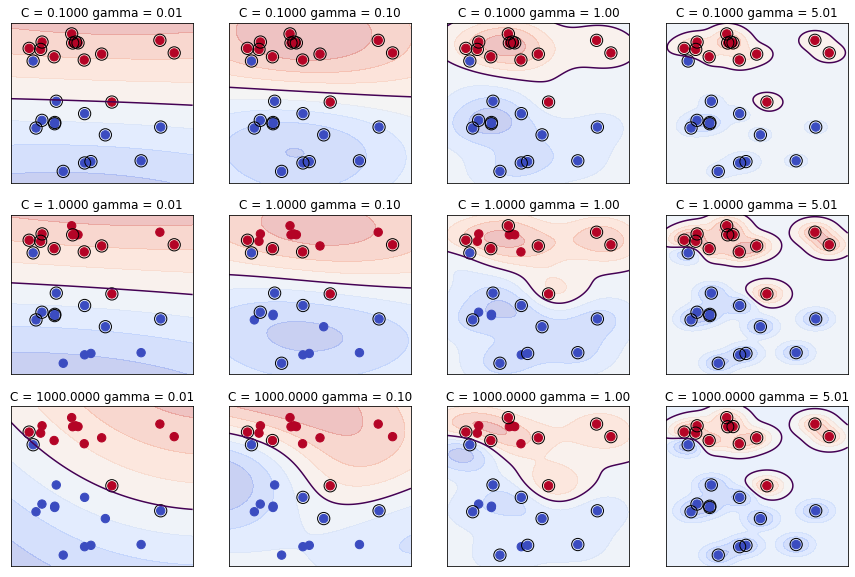

In [0]:
colors = [plt.cm.tab10(0), plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(1)]

def make_handcrafted_dataset():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def plot_svm(log_C, log_gamma, ax=None):
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    predictions = svm.decision_function(X_grid)
    ax.contourf(x_grid, y_grid, predictions.reshape(x_grid.shape), alpha=.3, cmap='coolwarm') #, colors=colors)
    ax.contour(x_grid, y_grid, predictions.reshape(x_grid.shape), levels=[0])

    # plot data
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm')
    # plot support vectors
    support_vectors = svm.support_
    ax.scatter(X[support_vectors, 0], X[support_vectors, 1], facecolor='none', edgecolor='k', linewidths=1, s=150)
    ax.set_title("C = %.4f gamma = %.2f" % (C, gamma))

X, y = make_handcrafted_dataset()

# create a grid for plotting decision functions...
x_lin = np.linspace(X[:, 0].min() - .5, X[:, 0].max() + .5, 1000)
y_lin = np.linspace(X[:, 1].min() - .5, X[:, 1].max() + .5, 1000)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
    
fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'xticks':(), 'yticks': ()})

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, [-2, -1, 0, .7]):
        plot_svm(log_C=C, log_gamma=gamma, ax=a)

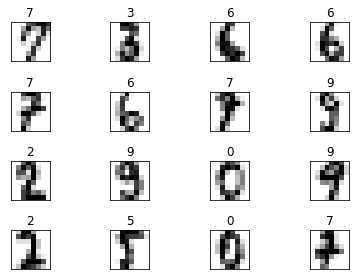

In [0]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, stratify=digits.target, random_state=0)

fig, axes = plt.subplots(4, 4)
for x, y, ax in zip(X_train, y_train, axes.ravel()):
    ax.set_title(y)
    ax.imshow(x.reshape(8, 8), cmap="gray_r")
    ax.set_xticks(())
    ax.set_yticks(())
plt.tight_layout()

In [0]:
scaled_svc = make_pipeline(StandardScaler(), SVC())
print(np.mean(cross_val_score(SVC(), X_train, y_train, cv=10)))
print(np.mean(cross_val_score(scaled_svc, X_train, y_train, cv=10)))

0.9873742399115534
0.9769872857932558


In [0]:
# X_train.std() is also good for global scaling - if the features were on the same scale.
# this dataset is very atypical.
print(np.mean(cross_val_score(SVC(gamma=(1. / (X_train.shape[1] * X_train.var()))), X_train, y_train, cv=10)))

0.9873742399115534


In [0]:
np.set_printoptions(precision=6, suppress=True)
# using pipeline of scaler and SVC. Could also use SVC and rescale gamma
param_grid = {'svc__C': np.logspace(-3, 2, 6),
              'svc__gamma': np.logspace(-3, 2, 6) / X_train.shape[0]}
param_grid

{'svc__C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ]),
 'svc__gamma': array([0.000001, 0.000007, 0.000074, 0.000742, 0.007424, 0.074239])}

In [0]:
grid = GridSearchCV(scaled_svc, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            

In [0]:
results = pd.DataFrame(grid.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.349261,0.003556,0.021352,0.000218,0.001,7.4239e-07,"{'svc__C': 0.001, 'svc__gamma': 7.423904974016...",0.377778,0.096296,0.096296,0.096296,0.177778,0.185185,0.162963,0.380597,0.291045,0.283582,0.214782,0.105669,26
1,0.347186,0.001201,0.021367,0.000139,0.001,7.4239e-06,"{'svc__C': 0.001, 'svc__gamma': 7.423904974016...",0.377778,0.096296,0.096296,0.096296,0.177778,0.185185,0.162963,0.380597,0.291045,0.283582,0.214782,0.105669,26
2,0.347577,0.001356,0.021335,0.000134,0.001,7.4239e-05,"{'svc__C': 0.001, 'svc__gamma': 7.423904974016...",0.377778,0.096296,0.096296,0.096296,0.185185,0.185185,0.170370,0.380597,0.291045,0.283582,0.216263,0.105086,23
3,0.347639,0.001257,0.021334,0.000172,0.001,0.00074239,"{'svc__C': 0.001, 'svc__gamma': 0.000742390497...",0.377778,0.096296,0.096296,0.096296,0.192593,0.185185,0.170370,0.380597,0.291045,0.283582,0.217004,0.104890,21
4,0.350879,0.004273,0.021317,0.000099,0.001,0.0074239,"{'svc__C': 0.001, 'svc__gamma': 0.007423904974...",0.385185,0.096296,0.096296,0.096296,0.200000,0.200000,0.185185,0.380597,0.291045,0.291045,0.222195,0.105377,19


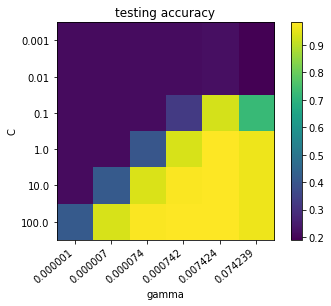

In [0]:
plt.title("testing accuracy")
plt.imshow(results.mean_test_score.values.reshape(6, 6))
plt.yticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.ylabel("C")
plt.xticks(range(len(param_grid['svc__gamma'])), ["{:.6f}".format(g) for g in param_grid['svc__gamma']], rotation=40, ha="right")
plt.xlabel("gamma")
plt.colorbar()

AttributeError: ignored

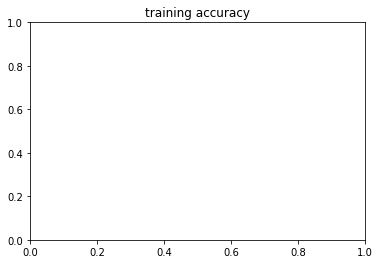

In [0]:
plt.title("training accuracy")
plt.imshow(results.mean_train_score.values.reshape(6, 6))
plt.yticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.ylabel("C")
plt.xticks(range(len(param_grid['svc__gamma'])), ["{:.6f}".format(g) for g in param_grid['svc__gamma']], rotation=40, ha="right")
plt.xlabel("gamma")
plt.colorbar()

In [0]:
from sklearn.kernel_approximationmation import RBFSampler
gamma = grid.best_params_['svc__gamma']
approx_rbf = RBFSampler(gamma=gamma, n_features=100)
approx_rbf.tran

In [0]:
"""
===================================================================
Support Vector Regression (SVR) using linear and non-linear kernels
===================================================================

Toy example of 1D regression using linear, polynomial and RBF kernels.

"""
print(__doc__)

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

###############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

###############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, degree=3, epsilon=.1, coef0=1)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

###############################################################################
# look at the results
lw = 2
plt.scatter(X, y, color='darkorange', label='data')

plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')

plt.scatter(X[svr_rbf.support_], y[svr_rbf.support_], facecolor="none", edgecolor="k", marker='8',
            label='rbf support vectors', s=100)
plt.scatter(X[svr_poly.support_], y[svr_poly.support_], facecolor="none", edgecolor="k", marker='s',
            label='poly support vectors', s=100)

plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [0]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, stratify=digits.target, random_state=0)

In [0]:
from sklearn.kernel_approximation import RBFSampler
gamma = 1. / (X_train.shape[1] * X_train.var())
approx_rbf = RBFSampler(gamma=gamma, n_components=5000)
print(X_train.shape)
X_train_rbf = approx_rbf.fit_transform(X_train)
print(X_train_rbf.shape)

In [0]:
np.mean(cross_val_score(LinearSVC(), X_train, y_train, cv=10))

In [0]:
np.mean(cross_val_score(SVC(gamma=gamma), X_train, y_train, cv=10))

In [0]:
np.mean(cross_val_score(LinearSVC(), X_train_rbf, y_train, cv=10))

In [0]:
from sklearn.kernel_approximation import Nystroem
nystroem = Nystroem(gamma=gamma, n_components=200)
X_train_ny = nystroem.fit_transform(X_train)
print(X_train_ny.shape)

In [0]:
from sklearn.svm import LinearSVC

In [0]:
np.mean(cross_val_score(LinearSVC(), X_train_ny, y_train, cv=10))

In [0]:
rng = np.random.RandomState(0)
w = rng.normal(size=(X_train.shape[1], 100))
X_train_wat = np.tanh(scale(np.dot(X_train, w)))
print(X_train_wat.shape)

In [0]:
np.mean(cross_val_score(LinearSVC(), X_train_wat, y_train, cv=10))